# EXACT SAMPLING AND COUPLING-FROM-THE-PAST APPLIED TO 2D-ISING MODEL

A. Bayirli & B. Göktürk (Boğaziçi Ünv.)

### Abstract

Monte Carlo methods allow us to sample from a desired distribution by various methods, one of the most popular one is the Markov Chain Monte Carlo. By constructing an ergodic Markov chain and running it many steps, one can sample from the stationary distribution of the chain which approximates the desired distribution. Running times of these chains are not easily determined so it would be beneficial if there would be an exact sampling mechanism which decides the stopping the chain and outputs an exact sample from the desired distribution. Perfect sampling method which was proposed by Prop and Wilson (1996) does exactly this using couplings with chains that runs from the past up until the present, where the distance into the past that one needs to go is determined during the running of the algorithm itself.

In this work, we implement the perfect sampling method with one of the most popular and well-studied models of statistical mechanics, 2-D Ising Model. It consists of spins interacting locally and possibly with the environment. We implement the interaction of the spins with the environment via heat-bath algorithm as a time-dependent random map in the coupling-from-the-past framework. This mechanism is supposed to create exact samples from the Ising model.


### Exact Sampling

Exact sampling is a technique for eliminating the necessity of determining the time for initialization bias to wear off. To solve this problem, the reasonable idea is that we start sampling from all the possible states and continue until they yield the exact same state for random amount of time, coupling time. The intuition is that when they coalesce at single state, the burn-in period is over and we can start drawing samples from the stationary state . Even though this intuition is flawed, coupling is one of the essential parts of the method we will examine for exact sampling: coupling from the past (CFTP). 


<img style="float: center;" src="cftp1.png">

<img style="float: center;" src="cftp2.png">

### Ising Model and Heat Bath Algorithm
* Consist of a collection of  small interacting magnets; each magnet may be alligned UP or DOWN.
* Magnets that are close to each other (in the close neighborhood) prefer to be alligned in the same direction.
* The energy of the configuration is described by: $$ E = \sum_{<i,j>}{\sigma_i \sigma_j}$$

where $<i,j>$ denotes neighborhood.
* The probability of a particiular configuration is given by Boltzman distribution:
$$ \pi(\sigma) = \frac{e^{-\beta E(\sigma)}}{Z}$$
     
Wher $\beta$ is the inverse temperature and $Z$ is the partition function (generally hard to compute).

* Sampling from the Ising Model: Thermalize all the spins with the local enviroment with the Heath Bath algorithm.




<img style="float: center;" src="ordering.png">

<img style="float: center;" src="halforder.png">

In [1]:
import random, math, pylab
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as patches

In [8]:
def plot_spins(conf, L, label, k):
    s = 1.0 / L
    for i_c in range(len(conf)):
        c = conf[i_c]
        colors = {}
        for i in range(L*L):
            if(c[i] == 1):
                colors[str(i)] = '#017890'
            else:
                colors[str(i)] = '#DF7782'
        #print(colors)
        for l in range(L ** 2):
            x, y = ((l // L) + 0.5) * s, ((l - (l // L) * L) + 0.5) * s
            dy = c[l] * 0.85 / float(L)
            arrow = FancyArrowPatch((x, y - 0.5 * dy), (x, y + 0.5 * dy), \
                    fc= colors[str(l)], color='.2', lw=0, alpha=.8, \
                    arrowstyle="Simple, head_length=" + str(0.6 * 150 * s) \
                    + ", head_width=" + str(0.9 * 150 * s) + ", tail_width=" \
                    + str(0.9 * 40 * s))
            pylab.gca().add_patch(arrow)
            if(l == k):
                pylab.gca().add_patch(patches.Rectangle((x-0.14, y-0.14),0.28,0.28,linewidth=3,fill=False))
        pylab.axis('scaled')
        pylab.axis([0, 1, 0, 1])
        pylab.gca().set_xticks([])
        pylab.gca().set_yticks([])
        [pylab.axhline(y=(i * s), ls='--', c='.2', lw=0.5) for i in range(L)]
        [pylab.axvline(x=(j * s), ls='--', c='.2', lw=0.5) for j in range(L)]
        pylab.title('All UP \n ' + label)
    
def plot_configurations(conf1,conf2, L, label,k, filename, save = False):
    pylab.subplot(1, 2, 1)
    plot_spins(conf1, L, label, k)
    pylab.subplot(1, 2, 2)
    plot_spins(conf2, L, label, k)
    pylab.tight_layout()
    if(save == True):
        pylab.savefig(filename + ".jpg")
    pylab.show()
    pylab.clf()

### Coupling from the past (CFTP) algorithm for the Ising Model

In [12]:
def ising_couple(size):
    L = size
    N = L * L
    nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N, #define the neighborhood of each site
                (i // L) * L + (i - 1) % L, (i - L) % N) \
                                        for i in range(N)}
    T = 4.0 #temperature
    beta = 1.0 / T #inverse temperature
    step_len = 100 #maximum step to go backward for CFTP
    random.seed(12)
    rand_k = [random.randint(0, N - 1) for i in range(step_len)] #random site update parameters
    rand_Upsilon = [random.uniform(0.0, 1.0) for i in range(step_len)] #probability to update the site up or down
    reverse = list(reversed(range(step_len)))
    flag = 0
    while(True):
        for j in range(1,step_len+1):
            print("Trying {} step".format(j))
            S0 = [1] * N
            S1 = [-1] * N
            coupling_time = []
            for m in reversed(range(j)):
                k = rand_k[m]
                Upsilon = rand_Upsilon[m]
                if(j==26): #plot the configurations at t = -26 (we know the number by random seed for 3x3 model by running the function and observe coalesence)
                    plot_configurations([S0],[S1],L,'Time: ' + str(-m) + "\n" + 'Prob = ' + str(round(Upsilon,2)),k, save = True, filename = str(m))
                h = sum(S0[nn] for nn in nbr[k]) #calculate the magnetic field in the neighborhood
                S0[k] = -1
                if Upsilon < 1.0 / (1.0 + math.exp(-2.0 * beta * h)):
                    S0[k] = 1 #make the spin up if u < prob(up)
                h = sum(S1[nn] for nn in nbr[k])
                S1[k] = -1
                if Upsilon < 1.0 / (1.0 + math.exp(-2.0 * beta * h)):
                    S1[k] = 1 #make the spin up if u < prob(up)
                n_diff = sum(abs(S0[i] - S1[i]) for i in range(N))
                if n_diff == 0: #if two configurations are the same (i.e coallesced) break the while loop
                    coupling_time.append(-m)
                    print('coupling time:', min(coupling_time))
                    flag = 1
                else:
                    print('not coalesced! at {}'.format(-m))
            if flag == 1:
                return

Trying 1 step
not coalesced! at 0
Trying 2 step
not coalesced! at -1
not coalesced! at 0
Trying 3 step
not coalesced! at -2
not coalesced! at -1
not coalesced! at 0
Trying 4 step
not coalesced! at -3
not coalesced! at -2
not coalesced! at -1
not coalesced! at 0
Trying 5 step
not coalesced! at -4
not coalesced! at -3
not coalesced! at -2
not coalesced! at -1
not coalesced! at 0
Trying 6 step
not coalesced! at -5
not coalesced! at -4
not coalesced! at -3
not coalesced! at -2
not coalesced! at -1
not coalesced! at 0
Trying 7 step
not coalesced! at -6
not coalesced! at -5
not coalesced! at -4
not coalesced! at -3
not coalesced! at -2
not coalesced! at -1
not coalesced! at 0
Trying 8 step
not coalesced! at -7
not coalesced! at -6
not coalesced! at -5
not coalesced! at -4
not coalesced! at -3
not coalesced! at -2
not coalesced! at -1
not coalesced! at 0
Trying 9 step
not coalesced! at -8
not coalesced! at -7
not coalesced! at -6
not coalesced! at -5
not coalesced! at -4
not coalesced! at -3


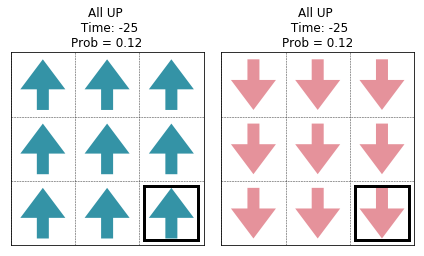

not coalesced! at -25


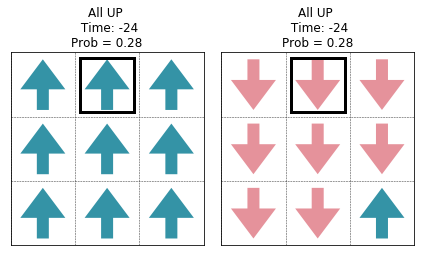

not coalesced! at -24


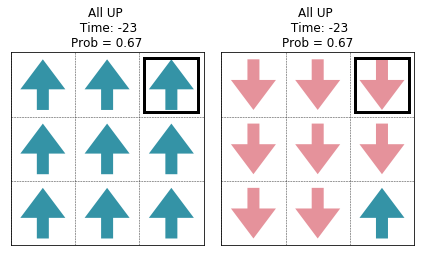

not coalesced! at -23


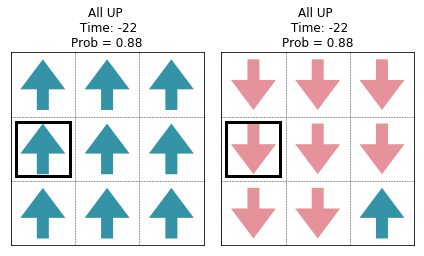

not coalesced! at -22


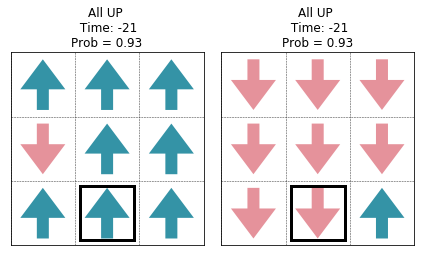

not coalesced! at -21


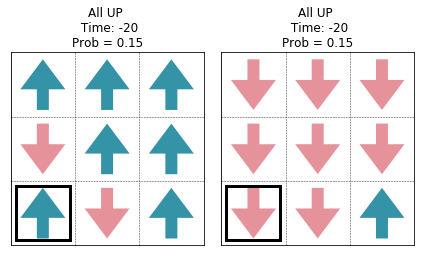

not coalesced! at -20


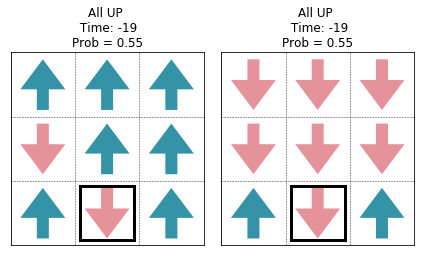

not coalesced! at -19


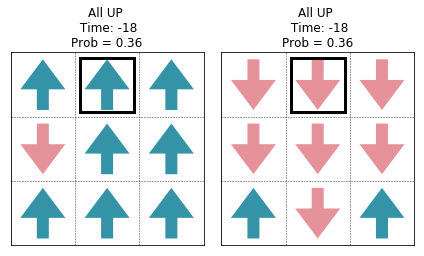

not coalesced! at -18


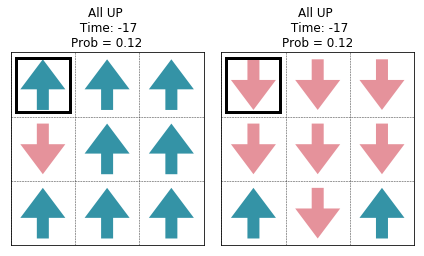

not coalesced! at -17


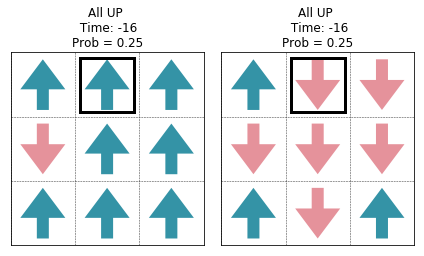

not coalesced! at -16


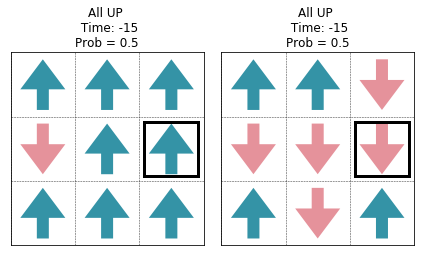

not coalesced! at -15


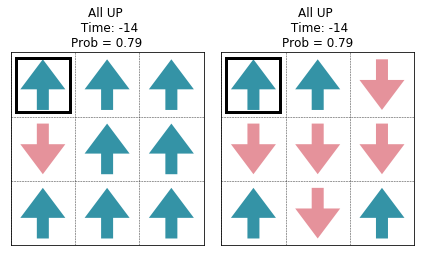

not coalesced! at -14


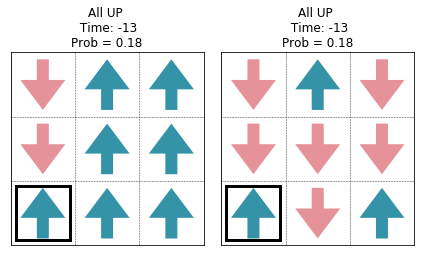

not coalesced! at -13


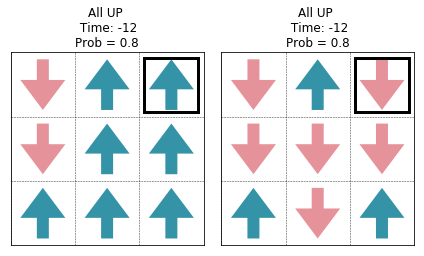

not coalesced! at -12


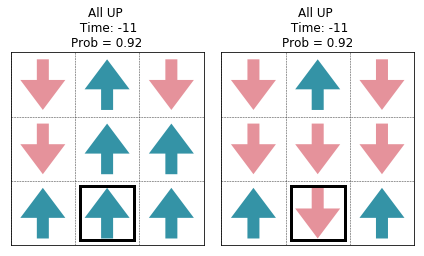

not coalesced! at -11


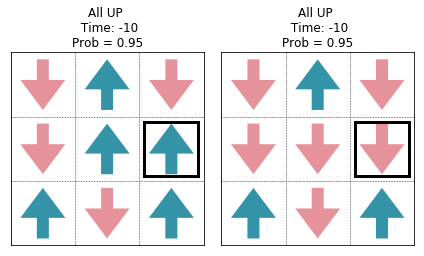

not coalesced! at -10


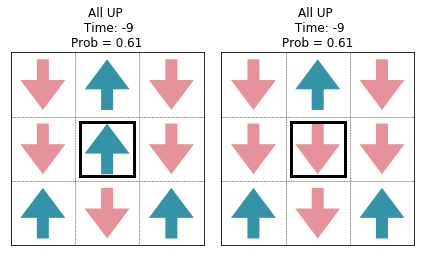

coupling time: -9


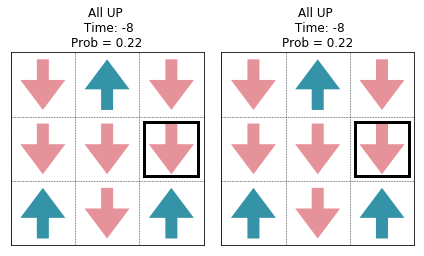

coupling time: -9


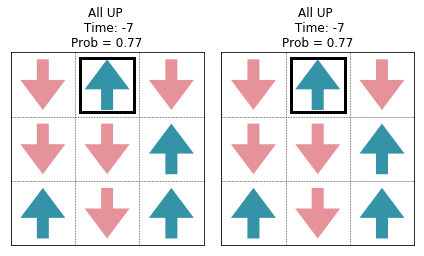

coupling time: -9


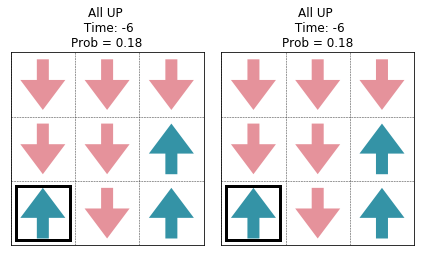

coupling time: -9


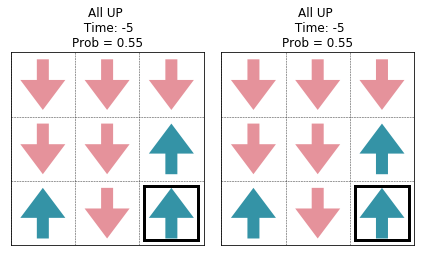

coupling time: -9


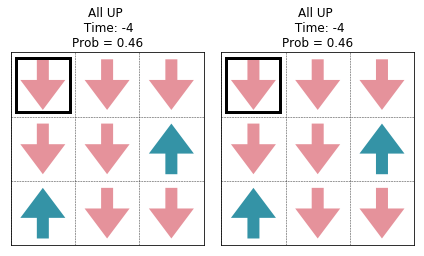

coupling time: -9


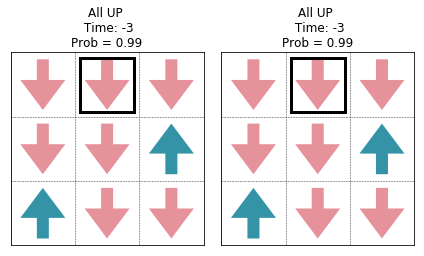

coupling time: -9


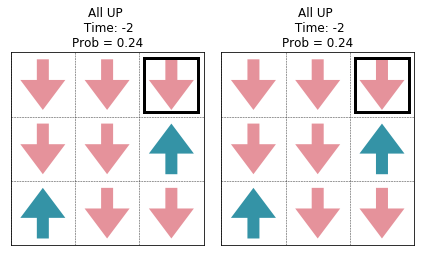

coupling time: -9


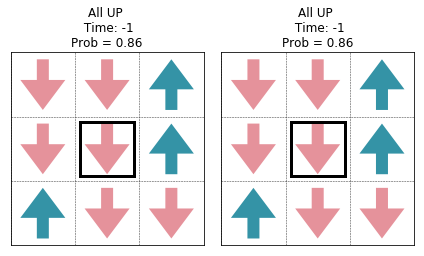

coupling time: -9


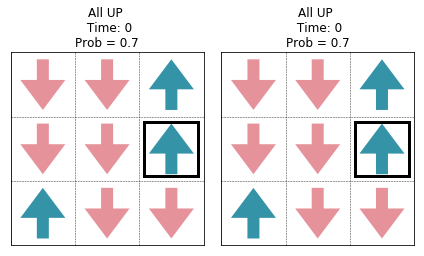

coupling time: -9


In [13]:
#try for 3x3 Ising model
ising_couple(3)

### References
* Propp J. G, Wilson D. B. (1996) Exact sampling with coupled Markov chains and applications to statistical mechanics, Random Structures & Algorithms 9, 223-252
* Krauth W., Statistical Mechanics: Algorithms and Computation, Oxford University Press